In [1]:
# Import necessary libraries
import os
import torch
import mlflow
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Enable MLflow autologging 
mlflow.pytorch.autolog()

2024/10/24 14:56:45 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.4.1, but the installed version is 2.5.0. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.


In [3]:
# Load the cleaned datasets (from Task 1)
fraud_data = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/cleaned_data/merged_data.csv')
creditcard_data = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/cleaned_data/Preprocessed_Creditcard_Data.csv')

# Drop unnecessary columns for training
fraud_data = fraud_data.drop(columns=['signup_time', 'purchase_time', 'user_id', 'device_id', 
                                      'ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address'], errors='ignore')

print('the merged fraud data')
display(fraud_data.head())

print('credit data')

display(creditcard_data.head())

the merged fraud data


,purchase_value,sex,age,class,time_diff,transaction_count,hour_of_day,day_of_week,purchase_value_scaled,source_Direct,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,47,0,30,0,1008.948611,1,3,6,0.549607,False,...,False,False,False,False,False,False,False,False,False,False
1,15,0,34,0,342.121389,1,20,2,-1.197335,False,...,False,False,False,False,False,False,False,False,False,False
2,44,1,29,0,554.870556,1,23,5,0.385831,False,...,False,False,False,False,False,False,False,False,False,False
3,55,0,30,0,2122.471389,1,16,5,0.986342,True,...,False,False,False,False,False,False,False,False,False,False
4,51,0,37,0,2847.105278,1,4,1,0.767974,False,...,False,False,False,False,False,False,False,False,False,False


credit data


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,time_in_days,Amount_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,0.244200
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,-0.342584
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000012,1.158900
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000012,0.139886
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000023,-0.073813


In [4]:
# Separate features and targets for Fraud Data
X_fraud = fraud_data.drop(columns=['class'])  # Feature set
y_fraud = fraud_data['class']  # Target

# Separate features and targets for Credit Card Data
X_credit = creditcard_data.drop(columns=['Class'])  # Feature set
y_credit = creditcard_data['Class']  # Target

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_fraud, y_fraud = smote.fit_resample(X_fraud, y_fraud)
X_credit, y_credit = smote.fit_resample(X_credit, y_credit)

# Train-Test Split for both datasets
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42)
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42)

# Normalize the data (Standard Scaling)
scaler = StandardScaler()
X_fraud_train = scaler.fit_transform(X_fraud_train)
X_fraud_test = scaler.transform(X_fraud_test)
X_credit_train = scaler.fit_transform(X_credit_train)
X_credit_test = scaler.transform(X_credit_test)

# Convert the datasets into PyTorch tensors
X_fraud_train_tensor = torch.tensor(X_fraud_train, dtype=torch.float32)
y_fraud_train_tensor = torch.tensor(y_fraud_train.values, dtype=torch.float32)
X_fraud_test_tensor = torch.tensor(X_fraud_test, dtype=torch.float32)
y_fraud_test_tensor = torch.tensor(y_fraud_test.values, dtype=torch.float32)

X_credit_train_tensor = torch.tensor(X_credit_train, dtype=torch.float32)
y_credit_train_tensor = torch.tensor(y_credit_train.values, dtype=torch.float32)
X_credit_test_tensor = torch.tensor(X_credit_test, dtype=torch.float32)
y_credit_test_tensor = torch.tensor(y_credit_test.values, dtype=torch.float32)

# DataLoader for batching
batch_size = 16
train_loader_fraud = torch.utils.data.DataLoader(TensorDataset(X_fraud_train_tensor, y_fraud_train_tensor), batch_size=batch_size, shuffle=True)
test_loader_fraud = torch.utils.data.DataLoader(TensorDataset(X_fraud_test_tensor, y_fraud_test_tensor), batch_size=batch_size)

train_loader_credit = torch.utils.data.DataLoader(TensorDataset(X_credit_train_tensor, y_credit_train_tensor), batch_size=batch_size, shuffle=True)
test_loader_credit = torch.utils.data.DataLoader(TensorDataset(X_credit_test_tensor, y_credit_test_tensor), batch_size=batch_size)


In [5]:
# Early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0


In [6]:
# Model definitions (MLP, CNN, RNN, LSTM)
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class CNNModel(nn.Module):
    def __init__(self, input_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * input_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.sigmoid(self.fc1(x))
        return x

class RNNModel(nn.Module):
    def __init__(self, input_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        h0 = torch.zeros(1, x.size(0), 32)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = torch.sigmoid(self.fc(out[:, -1, :]))
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        h0 = torch.zeros(1, x.size(0), 32)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), 32)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))
        out = torch.sigmoid(self.fc(out[:, -1, :]))
        return out

In [8]:
# Training loop with MLflow tracking
def train_model(model, train_loader, optimizer, criterion, num_epochs=10, patience=5, model_name="model"):
    early_stopper = EarlyStopping(patience=patience)
    model.train()
    
    with mlflow.start_run(run_name=model_name):
        for epoch in range(num_epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()  # Clear gradients
                y_pred = model(X_batch).squeeze()  # Forward pass
                loss = criterion(y_pred, y_batch)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
            
            # Log loss for each epoch
            mlflow.log_metric('loss', avg_loss, step=epoch)

            # Early stopping
            early_stopper(avg_loss)
            if early_stopper.early_stop:
                print("Early stopping triggered!")
                break

In [9]:
# Model evaluation
# Updated PyTorch model evaluation function
def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch).squeeze()
            preds = (y_pred > 0.5).float()  # Convert probabilities to 0/1
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Accuracy: {accuracy:.4f}')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [11]:
# Initialize models for both fraud and credit datasets
input_size_fraud = X_fraud_train.shape[1]
input_size_credit = X_credit_train.shape[1]

mlp_model_fraud = MLPModel(input_size_fraud)
cnn_model_fraud = CNNModel(input_size_fraud)
rnn_model_fraud = RNNModel(input_size_fraud)
lstm_model_fraud = LSTMModel(input_size_fraud)

mlp_model_credit = MLPModel(input_size_credit)
cnn_model_credit = CNNModel(input_size_credit)
rnn_model_credit = RNNModel(input_size_credit)
lstm_model_credit = LSTMModel(input_size_credit)

# Set loss function and optimizer
criterion = nn.BCELoss()

# Train and evaluate each model for both fraud and credit data
models = {
    "MLP_Fraud": mlp_model_fraud,
    "CNN_Fraud": cnn_model_fraud,
    "RNN_Fraud": rnn_model_fraud,
    "LSTM_Fraud": lstm_model_fraud,
    "MLP_Credit": mlp_model_credit,
    "CNN_Credit": cnn_model_credit,
    "RNN_Credit": rnn_model_credit,
    "LSTM_Credit": lstm_model_credit,
}

In [12]:
# saving the models
save_folder = 'C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/DL_saved_models'
os.makedirs(save_folder, exist_ok=True) 

# Function to save PyTorch models
def save_pytorch_model(model, model_name):
    save_path = os.path.join(save_folder, f'{model_name}.pt')
    torch.save(model.state_dict(), save_path)
    print(f'{model_name} saved at {save_path}')

In [13]:
# Training and evaluating each model with MLflow tracking
# Modify the existing model loop to include saving logic
for model_name, model in models.items():
    if isinstance(model, nn.Module):  # For PyTorch models
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        print(f"\nTraining {model_name}...")
        train_model(model, train_loader_fraud if "Fraud" in model_name else train_loader_credit, optimizer, criterion)
        print(f"Evaluating {model_name}...")
        evaluate_model(model, test_loader_fraud if "Fraud" in model_name else test_loader_credit)
        save_pytorch_model(model, model_name)  # Save PyTorch model
        print('----------------------------------------------------------------------------------------------------------------------------------------------------')
    else:  
        print("nothing to print")
        


Training MLP_Fraud...
Epoch [1/10], Loss: 0.2758
Epoch [2/10], Loss: 0.2280
Epoch [3/10], Loss: 0.2160
Epoch [4/10], Loss: 0.2159
Epoch [5/10], Loss: 0.2126
Epoch [6/10], Loss: 0.2002
Epoch [7/10], Loss: 0.1962
Epoch [8/10], Loss: 0.1919
Epoch [9/10], Loss: 0.1906
Epoch [10/10], Loss: 0.1914
Evaluating MLP_Fraud...
Accuracy: 0.9361
Precision: 0.9386
Recall: 0.9365
F1 Score: 0.9361
MLP_Fraud saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/DL_saved_models\MLP_Fraud.pt
----------------------------------------------------------------------------------------------------------------------------------------------------

Training CNN_Fraud...
Epoch [1/10], Loss: 0.2660
Epoch [2/10], Loss: 0.2022
Epoch [3/10], Loss: 0.1937
Epoch [4/10], Loss: 0.1895
Epoch [5/10], Loss: 0.1865
Epoch [6/10], Loss: 0.1853
Epoch [7/10], Loss: 0.1849
Epoch [8/10], Loss: 0.1831
Epoch [9/10], Loss: 0.1828
Epoch [10/10], Loss: 0.1824
Evaluating CNN_Fraud...
Accuracy: 0.9411
Precision: 0.945

### Model Explanability using shap

##### Multi-Layer Perceptron (MLP)

C:\Users\elbet\AppData\Local\Temp\ipykernel_70556\2991818032.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/elbet/OneDrive/De

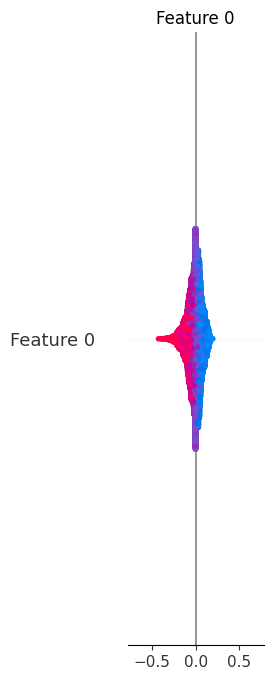

In [28]:
import shap
import torch

# Load the saved model weights from the .pt file
model.load_state_dict(torch.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/DL_saved_models/MLP_Fraud.pt'))

# Set the model to evaluation mode
model.eval()

# Define a custom prediction function for SHAP
def model_predict(input_numpy):
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32)  # Convert back to tensor
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        return model(input_tensor).detach().cpu().numpy()  # Return numpy predictions

# Convert test tensor to numpy array
X_fraud_test_numpy = X_fraud_test_tensor.numpy()

# Select a subset of your test data for SHAP
X_fraud_test_sample = X_fraud_test_numpy[:10]

# Use KernelExplainer for SHAP values
explainer = shap.KernelExplainer(model_predict, X_fraud_test_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_fraud_test_numpy)

# Visualize SHAP values
shap.summary_plot(shap_values, X_fraud_test_numpy)


##### CNN

In [30]:
model = cnn_model_fraud 
# Load the saved model weights from the .pt file
model.load_state_dict(torch.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/DL_saved_models/CNN_Fraud.pt'))

# Set the model to evaluation mode
model.eval()

# Define a custom prediction function for SHAP
def model_predict(input_numpy):
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32)  # Convert back to tensor
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        return model(input_tensor).detach().cpu().numpy()  # Return numpy predictions

# Convert test tensor to numpy array
X_fraud_test_numpy = X_fraud_test_tensor.numpy()

# Select a subset of your test data for SHAP
X_fraud_test_sample = X_fraud_test_numpy[:10]

# Use KernelExplainer for SHAP values
explainer = shap.KernelExplainer(model_predict, X_fraud_test_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_fraud_test_numpy)

# Visualize SHAP values
shap.summary_plot(shap_values, X_fraud_test_numpy)


C:\Users\elbet\AppData\Local\Temp\ipykernel_70556\3925450680.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/elbet/OneDrive/De

##### Recurrent Neural Network

In [ ]:
model = rnn_model_fraud 
# Load the saved model weights from the .pt file
model.load_state_dict(torch.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/DL_saved_models/RNN_Fraud.pt'))

# Set the model to evaluation mode
model.eval()

# Define a custom prediction function for SHAP
def model_predict(input_numpy):
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32)  # Convert back to tensor
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        return model(input_tensor).detach().cpu().numpy()  # Return numpy predictions

# Convert test tensor to numpy array
X_fraud_test_numpy = X_fraud_test_tensor.numpy()

# Select a subset of your test data for SHAP
X_fraud_test_sample = X_fraud_test_numpy[:10]

# Use KernelExplainer for SHAP values
explainer = shap.KernelExplainer(model_predict, X_fraud_test_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_fraud_test_numpy)

# Visualize SHAP values
shap.summary_plot(shap_values, X_fraud_test_numpy)


##### LSTM

In [ ]:
model = lstm_model_fraud 
# Load the saved model weights from the .pt file
model.load_state_dict(torch.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/DL_saved_models/LSTM_Fraud.pt'))

# Set the model to evaluation mode
model.eval()

# Define a custom prediction function for SHAP
def model_predict(input_numpy):
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32)  # Convert back to tensor
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        return model(input_tensor).detach().cpu().numpy()  # Return numpy predictions

# Convert test tensor to numpy array
X_fraud_test_numpy = X_fraud_test_tensor.numpy()

# Select a subset of your test data for SHAP
X_fraud_test_sample = X_fraud_test_numpy[:10]

# Use KernelExplainer for SHAP values
explainer = shap.KernelExplainer(model_predict, X_fraud_test_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_fraud_test_numpy)

# Visualize SHAP values
shap.summary_plot(shap_values, X_fraud_test_numpy)
